# Continuous RL - Aggregation and Tile Coding 

In [1]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # shows progress bar
from envs import Maze
from utils import plot_policy , plot_tabular_cost_to_go , test_agent , plot_stats , seed_everything
%matplotlib inline

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# State Aggregation

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env) # to enable reproducability

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


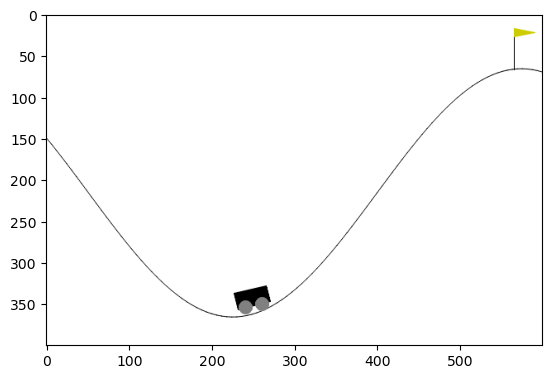

In [3]:
env.reset()
frame = env.render(mode = 'rgb_array')
plt.imshow(frame)

In [4]:
class stateAggregationEnv(gym.ObservationWrapper):
    def __init__(self , env , bins , low , high):
        # low = [-1.2 , -0.07] , high = [0.6 , 0.07] , bins=[20,20] -> 400 states
        super().__init__(env)
        self.buckets = [np.linspace(l , h , b-1) for l , h , b in zip(low , high , bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec = bins.tolist())
    
    def obsveration(self , states):
        indices = tuple(np.digitize(cont , buck) for cont , buck in zip(states , self.buckets))
        return indices

In [5]:
bins = np.array ([20,20])
low = env.observation_space.low
high = env.observation_space.high
env = gym.make('MountainCar-v0')
seed_everything(env) # to enable reproducability
env.reset()
saenv = stateAggregationEnv(env , bins=bins , high=high , low=low)


In [6]:
# testing
print(f" Discrete : {saenv.observation_space} , {saenv.observation_space.sample()}")
print(f" Continuous : {env.observation_space} , {env.observation_space.sample()}")

 Discrete : MultiDiscrete([20 20]) , [6 0]
 Continuous : Box([-1.2  -0.07], [0.6  0.07], (2,), float32) , [ 0.1931209  -0.00855702]


In [7]:
def policy(state , epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.choice(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av==av.max()))

def agg_sarsa(action_values , policy , episodes , alpha=0.2 , gamma=0.99 , epsilon = 0.25):
    stats={'Returns' : []}
    for episode in tqdm(range(1 , episodes+1)):
        state = saenv.reset()
        action = policy(state , epsilon)
        done=False
        ep_return=0
        while not done:
            next_state , reward , done , _ = saenv.step(action)
            next_action = policy(next_state , epsilon)
            
            qsa_t = action_values[state][action]
            qsa_t_prime = action_values[next_state][next_action] 
            action_values[state][action] = qsa_t + alpha*(reward + gamma * qsa_t_prime - qsa_t)
            
            state = next_state
            action = next_action
            
            ep_return += reward
            
        stats['Returns'].append(ep_return)
            
    return action_values , stats

In [8]:
action_values = np.zeros((20,20,3))
action_values , stats = agg_sarsa(action_values , policy , 100 )

  0%|                                                                                   | 0/100 [00:00<?, ?it/s]


NotImplementedError: 

# Tile Coding

In [9]:
env =  gym.make('MountainCar-v0')
seed_everything(env)

In [10]:
class tileCodingEnv(gym.ObservationWrapper):
    def __init__ (self , env , bins , low , high , n):
        super().__init__(env)
        self.tilings = self._create_tilings(bins , high , low , n)
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist() * n )
        
    def observation(self , states):
        indices=[]
        for t in self.tilings:
            tiling_indices = tuple(np.digitize(i , b) for i,b in zip(states , t))
            indices.append(tiling_indices)
        return indices
    
    def _create_tilings(self , bins , high , low , n):
        tilings=[]
        displacement_vector = np.arange(1,2*len(bins) , 2)
        for i in range(1 , n+1):
            low_i = low-random.random()*0.2*low
            high_i = high + random.random()*0.2*high
            segment_sizes = (high_i - low_i)/bins
            displacements = displacement_vector * i % n
            displacements = displacements*(segment_sizes/n)
            low_i += displacements
            high_i += displacements
            buckets_i = [np.linspace(l , h , b-1) for l , h , b in zip(low_i , high_i , bins)]
            tilings.append(buckets_i)
        return tilings
            

In [11]:
tilings = 4
bins = np.array([20,20])
low = env.observation_space.low
high = env.observation_space.high
tcenv = tileCodingEnv(env , bins=bins , high=high , low=low , n=tilings)

In [12]:
# testing
print(f" Discrete : {tcenv.observation_space} , {tcenv.observation_space.sample()}")
print(f" Continuous : {env.observation_space} , {env.observation_space.sample()}")

 Discrete : MultiDiscrete([20 20 20 20 20 20 20 20]) , [ 8 13 11 13  8 12  5  5]
 Continuous : Box([-1.2  -0.07], [0.6  0.07], (2,), float32) , [ 0.1931209  -0.00855702]


In [23]:
def policy(state , epsilon=0.2):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i , idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
            
        av = np.mean(av_list , axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

def tc_sarsa(action_values , policy , episodes , alpha=0.2 , gamma=0.99 , epsilon = 0.25):
    stats={'Returns' : []}
    for episode in tqdm(range(1 , episodes+1)):
        state = tcenv.reset()
        action = policy(state , epsilon)
        done=False
        ep_return=0
        while not done:
            next_state , reward , done , _ = tcenv.step(action)
            next_action = policy(next_state , epsilon)
            
            for i , (idx , next_idx) in enumerate(zip(state,next_state)):
                qsa_t = action_values[i][idx][action]
                qsa_t_prime = action_values[i][next_idx][next_action] 
                action_values[i][idx][action] = qsa_t + alpha*(reward + gamma * qsa_t_prime - qsa_t)
            
            state = next_state
            action = next_action
            
            ep_return += reward
            
        stats['Returns'].append(ep_return)
            
    return action_values , stats

In [28]:
action_values = np.zeros((4,20,20,3))
action_values , stats = tc_sarsa(action_values , policy , 20000 )

100%|█████████████████████████████████████████████████████████████████████| 20000/20000 [07:29<00:00, 44.45it/s]


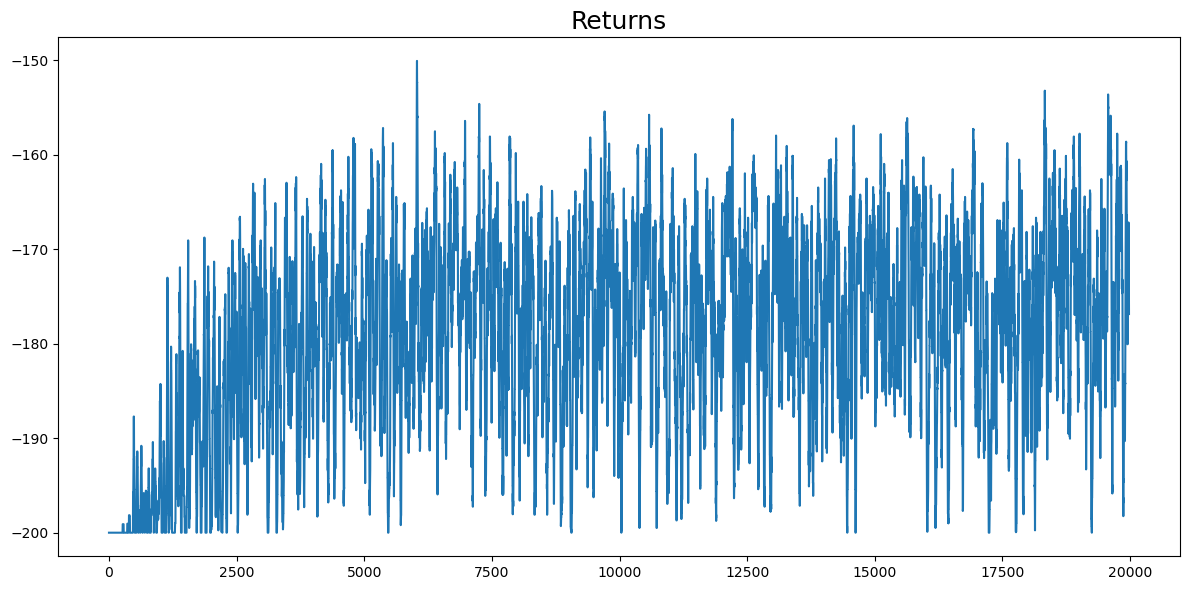

In [30]:
plot_stats(stats)

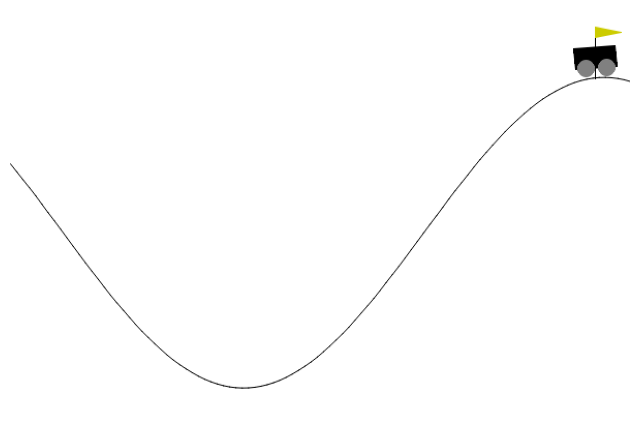

In [37]:
test_agent(tcenv , policy , 3)

C:\Users\Ali\Documents\RLwithPhil\code\utils.py:23: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probs_copy = max_prob_actions.copy().astype(np.object)


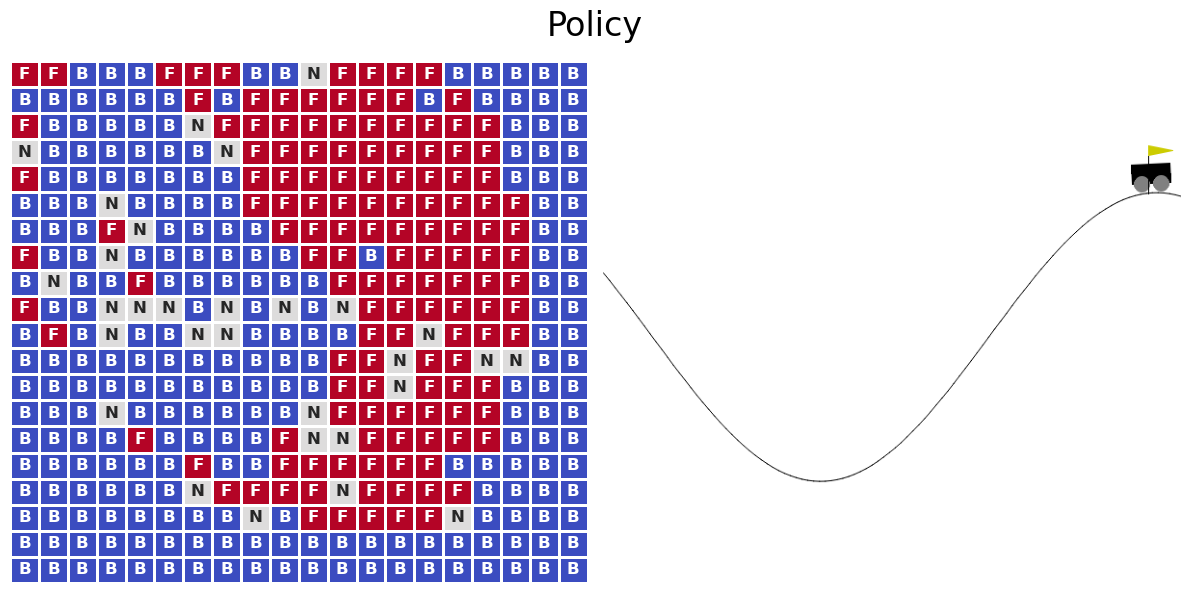

In [34]:
plot_policy(action_values.mean(axis=0) , env.render(mode='rgb_array') , action_meanings={0:'B' , 1:'N' , 2:'F'})

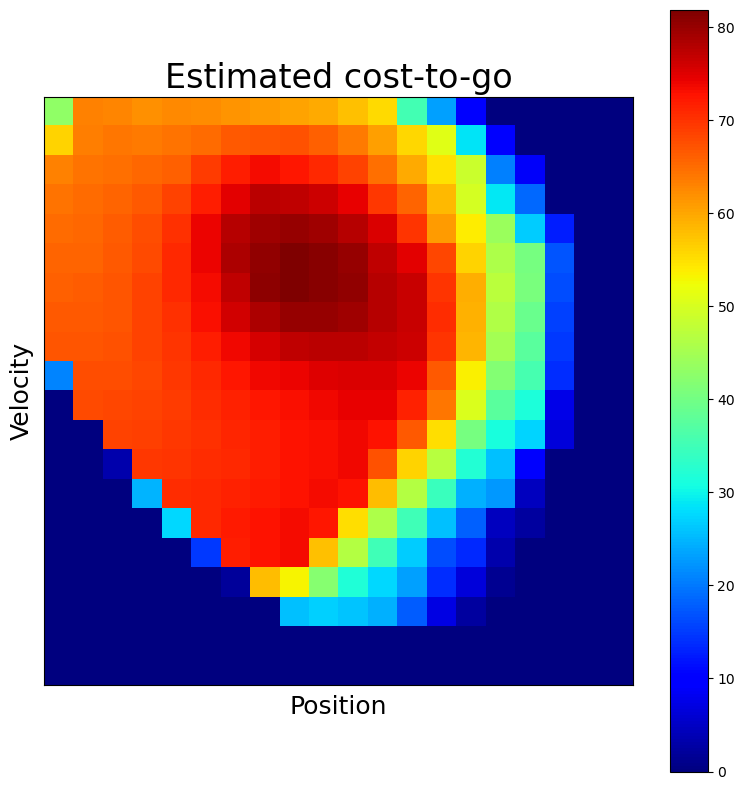

In [36]:
plot_tabular_cost_to_go(action_values.mean(axis=0) , xlabel='Position' , ylabel='Velocity')